<a href="https://colab.research.google.com/github/Mobad225/Coin-Detection-Circle-Detection-/blob/master/Circle%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
files.upload()

{}

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

path = 'final.jpg'
img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB);

# Function to print photos

In [0]:
def print_photo(data_to_show, c_style = None, single = True, title = None,
                true_size = False):
  if true_size == True:
    #USER SCREEN DPI
    dpi, dims = 125, data_to_show.shape
    dims_inch = (dims[1]/dpi, dims[0]/dpi)
    plt.figure(figsize=dims_inch)
  plt.axis('off')
  plt.title(title)
  if single:
    plt.imshow(data_to_show, cmap = plt.get_cmap(c_style))
    plt.show()
    plt.close()
    print()
    return
  else:
    for curr_img in data_to_show:
      plt.axis('off')
      plt.imshow(curr_img, cmap = plt.get_cmap(c_style))
      plt.show()
      plt.close()
      print()
    return

# Converting RGB Image to Grayscale

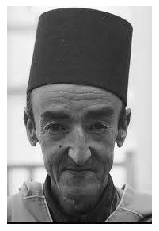

In [0]:
grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print_photo(grayscale_img, c_style = 'gray')

# Smoothing image by median filter

In [0]:
grayscale_median = cv2.medianBlur(grayscale_img, ksize = 7)

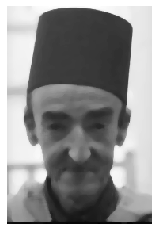

In [0]:
print_photo(grayscale_median, c_style = 'gray')

# Edge detection using Laplacian filter

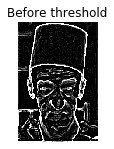

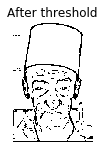

In [0]:
laplacian = cv2.convertScaleAbs(cv2.Laplacian(grayscale_median, ddepth = cv2.CV_8U, ksize = 5))
print_photo(laplacian, c_style = 'gray', title = 'Before threshold', true_size=True)
ret, laplacian = cv2.threshold(laplacian, 127, 255, cv2.THRESH_BINARY_INV)
print_photo(laplacian, c_style = 'gray', title = 'After threshold', true_size=True)

# Using bilateral filter to cartoonize

### Image size reduced to half, a small filter 9x9 is used 7 times

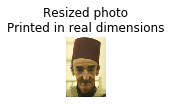

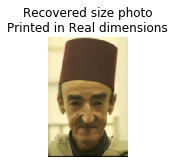

In [0]:
dim = (np.array(img.shape)).astype(int)
resized_img = cv2.resize(img, (dim[1]//2, dim[0]//2), interpolation = cv2.INTER_AREA)
print_photo(resized_img, true_size = True, title = 'Resized photo\nPrinted in real dimensions')
for rep in range(7):
  resized_img = cv2.bilateralFilter(resized_img, d = 5, sigmaColor = 5, 
                                    sigmaSpace = 7)
filtered_img = cv2.resize(resized_img, (dim[1], dim[0]), 
                          interpolation = cv2.INTER_LINEAR)
print_photo(filtered_img, true_size = True, title = 'Recovered size photo\nPrinted in Real dimensions')

# Adding both images (Edges + Cartoonized)

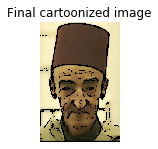

In [0]:
laplacian_mask = cv2.cvtColor(laplacian, cv2.COLOR_GRAY2RGB)
cartoonized = cv2.bitwise_and(filtered_img, laplacian_mask)
print_photo(cartoonized, title = 'Final cartoonized image', true_size= True)

#2 Coins Detection Using Hough Transform.

In [4]:
files.upload()

{}

In [0]:
!unzip -q dataset.zip -d  coins-dataset

In [0]:
!unzip -q test.zip -d  coins-dataset2

unzip:  cannot find or open test.zip, test.zip.zip or test.zip.ZIP.


#Reading dataset.

In [0]:
import os

coins = os.listdir("coins-dataset/new_dataset")
dataset = []
for imgName in coins:
  img =  cv2.cvtColor(cv2.imread("coins-dataset/new_dataset/"+imgName), cv2.COLOR_BGR2RGB)
  dataset.append(img)
dataset = np.array(dataset)
print(dataset.shape)

(6, 768, 576, 3)


# Bluring the image to remove unwanted details, applying hough circle to vote for best circle with given r.

# for the image in the pdf:
## ksize = 11, threshold_1 = 100, threshold_2 = 200, allow = 3.
* 1 pound, radius = 46.5 gives good results.
* 50 piastres, radius  = 38 gives good results.
* 25 piastres, radius  = 31 gives good results.

# for the images in the dataset prepared by (amr fahmy)
# using hough_circle (looping over all possible b):
## ksize = 21, threshold_1 = 10, threshold_2 = 100.
* 1 pound, radius = 70, allow  = 2, at_least = 60, gives good results.
* 50 piastres, radius = 56.5, allow  = 2, at_least = 60, gives good results.
* 25 piastres, radius = 38, allow  = 3, at_least = 45, gives good results.

# for the images in the dataset prepared by (amr fahmy)
# using hough_circle_theta (looping over all possible thetas):
## ksize = 21, threshold_1 = 10, threshold_2 = 100.
* 1 pound, radius = 67, allow  = 5, at_least = 60, gives good results.
* 50 piastres, radius = 54.5, allow  = 8, at_least = 79, gives good results.
* 25 piastres, radius = 39, allow  = 5, at_least = 100 gives good results.

In [0]:
# @image: image resulted from applying the edge detection algorithm (255: edge)
# @radiuses: array of radii to detect circles.
# @thres: threshould for taking votes  >= Maximum_votes - threshould.
# @at_least: the least number of votes to consider, useful if the image doesn't
#     contain the specified radii.
# hough_circle loops over the image and for each edge it votes for all possible 
#     centers of this edge with the given radius, by solving:
#     (x-a)^2 + (x-b)^2 = r^2, by iterating over all possible values of b and 
#     solving for a. Then by choosing the most votes from the accumulative array
#     and returning an array of circles with the most votes.
def hough_circle(image, radiuses, thres, at_least):
  circles = []
  for r in radiuses:
    H = np.zeros(image.shape)
    for i in range(len(image)):
      for j in range(len(image[0])):
        if image[i][j] == 255: #edge
          # loop through possible b
          for b in range(len(image[0])):
            # calculate a
            insqrt = r * r - (j-b)**2
            if  insqrt < 0.0:
              continue
            a = np.round(i - np.sqrt(insqrt)).astype(int)
            if a >= 0 and a < len(image):
              H[a,b] += 1
    mx = np.max(H)
    print(mx)
    H[H < mx - thres] = 0
    for i in range(len(image)):
      for j in range(len(image[0])):
        if H[i,j] >= mx-thres and H[i,j] >= at_least:
          circles.append((i,j,r))
  return circles

In [0]:
# @image: image resulted from applying the edge detection algorithm (255: edge)
# @radiuses: array of radii to detect circles.
# @thres: threshould for taking votes  >= Maximum_votes - threshould.
# @at_least: the least number of votes to consider, useful if the image doesn't
#     contain the specified radii.
# hough_circle loops over the image and for each edge it votes for all possible 
#     centers of this edge with the given radius, by solving: iterating over all
#     possible thetas(0, 360) and voting for a point with the following equations
#     a = y - r*sin(theta), b = x - r*cos(theta), precalculating the thetas for
#     faster computations. Then by choosing the most votes from the accumulative
#     array and returning an array of circles with the most votes.
def hough_circle_theta(image, radiuses, thres, at_least):
  circles = []
  sine = dict()
  cosine = dict()
  theta_range = np.linspace(0, 360, 360)
  for theta in theta_range:
    sine[theta] = np.sin(theta)
    cosine[theta] = np.cos(theta)
  for r in radiuses:
    H = np.zeros(image.shape)
    for i in range(len(image)):
      for j in range(len(image[0])):
        if image[i][j] == 255: #edge
          # loop through possible thetas
          for theta in theta_range:
            # calculate a,b
            b = np.round(j - r*cosine[theta]).astype(int)
            a = np.round(i - r*sine[theta]).astype(int)
            if a >= 0 and a < len(image) and b >= 0 and b < len(image[0]):
              H[a,b] += 1
    mx = np.max(H)
    #print(mx)
    H[H < mx - thres] = 0
    for i in range(len(image)):
      for j in range(len(image[0])):
        if H[i,j] >= mx-thres and H[i,j] >= at_least:
          circles.append((i,j,r))
  return circles

In [0]:
def fix(circles, EPS = 100):
  mask = np.ones(len(circles))
  for i in range(len(circles)):
    if mask[i] == 0:
      continue
    for j in range(i + 1, len(circles)):
      x1, x2, y1, y2 = circles[i][0], circles[j][0], circles[i][1], circles[j][1]
      dx, dy = x1-x2, y1-y2
      if dx**2 + dy**2 < EPS:
        mask[j] = 0
  ret = []
  for i in range(len(circles)):
    if mask[i] == 1:
      ret.append(circles[i])
  return ret

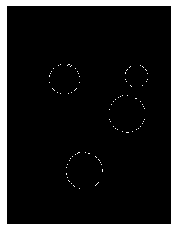

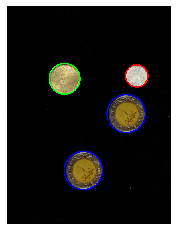

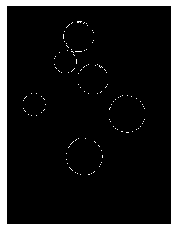

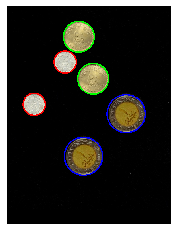

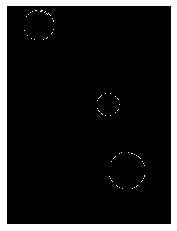

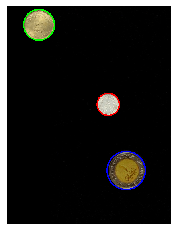

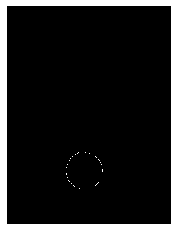

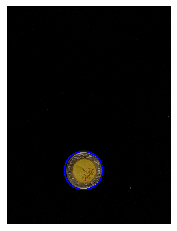

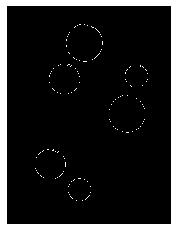

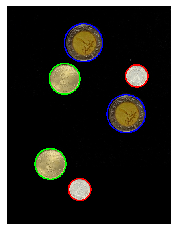

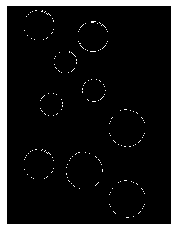

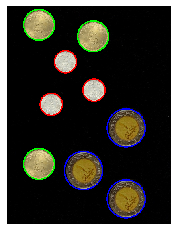

In [0]:
gray_scale_dataset = []
for i in range(len(dataset)):
  gray_scale_dataset.append(cv2.medianBlur(cv2.cvtColor(dataset[i], cv2.COLOR_BGR2GRAY), ksize = 21))
gray_scale_dataset = np.array(gray_scale_dataset)
# to print images.
for i,img in enumerate(gray_scale_dataset):
 #if i != len(gray_scale_dataset) - 1:
 #  continue;
 edges = cv2.Canny(img, 10, 100)
 print_photo(edges, c_style="gray", true_size=False)
 orig_image = dataset[i].copy()
 circles = fix(hough_circle_theta(edges,[67], 5, 60))
 for circle in circles:
   cv2.circle(orig_image,(circle[1],circle[0]),int(circle[2]),(0,0,255),4) #blue
 circles = fix(hough_circle_theta(edges, [54.5], 8, 79))
 for circle in circles:
  cv2.circle(orig_image,(circle[1],circle[0]),int(circle[2]),(0,255,0),4) #green
 circles = fix(hough_circle_theta(edges, [39], 5, 100))
 for circle in circles:
  cv2.circle(orig_image,(circle[1],circle[0]),int(circle[2]),(255,0,0),4) #red
 print_photo(orig_image, true_size= False)